In [1]:
import os
from pathlib import Path
from random import random
import shutil

def copy_file(source_directory, destination_directory, filename):
    destination_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy(source_directory/filename, destination_directory/filename)

def organize_dataset(root_folder, valid_probability=0.1):
    for root, dirs, files in os.walk(root_folder/'original'):
        path = root.split(os.sep)
        if len(path)<3:
            continue

        label = path[2]
        for file in files:
            channel = Path('train') if random()>valid_probability else Path('valid')
            source_directory = root_folder/'original'/label
            destination_directory = root_folder/channel/label
            copy_file(source_directory, destination_directory, file)

In [2]:
import zipfile

root = Path('data')
root.mkdir(exist_ok=True, parents=True)


if not (root/'original.zip').exists():
    print('Downloading dataset')
    !aws s3 cp s3://ch-workshop/data/original.zip data/original.zip

if not (root/'original').exists():
    print("Unzipping dataset")

    with zipfile.ZipFile(root/'original.zip', 'r') as zip_ref:
        zip_ref.extractall(root)

if not (root/'train').exists() and not (root/'valid').exists():
    print("Creating train/validation structure")
    organize_dataset(root)

download: s3://ch-workshop/data/original.zip to data/original.zip 
Unzipping dataset
Creating train/validation structure


## Datasets

In [3]:
import torchvision
import torch

train_dataset = torchvision.datasets.ImageFolder(
    root/'train',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ])
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=False, num_workers=4, pin_memory=True)

means = []
stdevs = []
for X, _ in train_dataloader:
    means.append(X.mean(dim=(0,2,3)))
    stdevs.append(X.std(dim=(0,2,3)))

mean = torch.stack(means, dim=0).mean(dim=0)
stdev = torch.stack(stdevs, dim=0).mean(dim=0)

In [10]:
mean, stdev

(tensor([0.6405, 0.6067, 0.5659]), tensor([0.2144, 0.2134, 0.2338]))

In [4]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])

train_dataset = torchvision.datasets.ImageFolder(root/'train', transform=train_transforms)


valid_transforms = transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])

valid_dataset = torchvision.datasets.ImageFolder(root/'valid', transform=valid_transforms)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

## Visualization

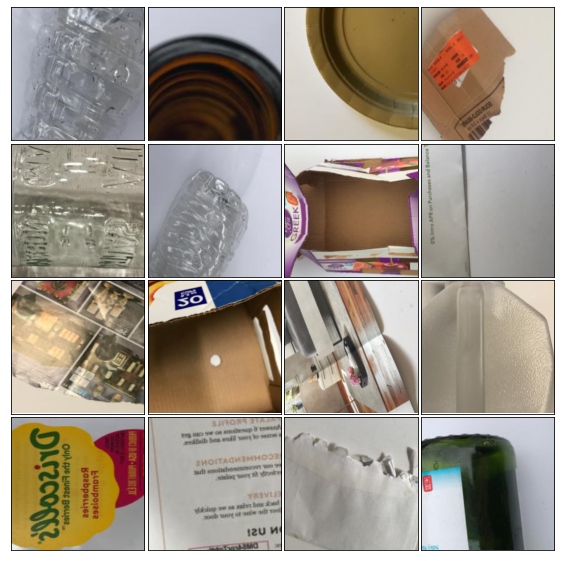

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def imshow(axis, inp):
    inp = inp.permute(1,2,0)
    inp = inp * stdev + mean
    axis.imshow(inp)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

fig = plt.figure(1, figsize=(30, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)

batch = next(iter(train_dataloader))

for img, ax in zip(batch[0], grid):
    imshow(ax, img)

## Training and Validation

In [7]:
def init_weight(module):
    if type(module) == torch.nn.Linear or type(module) == torch.nn.Conv2d:
        torch.nn.init.xavier_normal_(module.weight)

def get_net_finetune(lr=1e-5, weight_decay=0):
    resnet = torchvision.models.resnet18(pretrained=True)
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)

    params_1x = [param for name, param in resnet.named_parameters() if 'fc' not in str(name)]
    optimizer = torch.optim.Adam([{'params':params_1x}, {'params': resnet.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)
    return resnet, optimizer

def get_net_frozen(lr=1e-3, weight_decay=0):
    resnet = torchvision.models.resnet18(pretrained=True)
    for parameter in resnet.parameters():
        parameter.requires_grad = False

    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)

    optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)
    return resnet, optimizer

def get_net(lr=1e-3, weight_decay=0):
    resnet = torchvision.models.resnet18(pretrained=False)
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)

    resnet.apply(init_weight)

    optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)
    return resnet, optimizer

In [8]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu'):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()
        train_loss = torch.tensor(0., device=device)
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if valid_dataloader is not None:
            net.eval()
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            scheduler.step()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')

        if epoch%10==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')

        print()

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr, weight_decay, epochs = 1e-5, 5e-4, 100

net, optimizer = get_net_finetune(lr, weight_decay)
net = net.to(device)
criterion = torch.nn.CrossEntropyLoss()

net = train(net, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


Training for 100 epochs on cuda
Epoch 1/100
Training loss: 1.87
Training accuracy: 30.91
Valid loss: 1.43
Valid accuracy: 47.97

Epoch 2/100
Training loss: 1.23
Training accuracy: 54.84
Valid loss: 1.08
Valid accuracy: 58.54

Epoch 3/100
Training loss: 0.95
Training accuracy: 66.24
Valid loss: 0.89
Valid accuracy: 67.07

Epoch 4/100
Training loss: 0.81
Training accuracy: 72.64
Valid loss: 0.78
Valid accuracy: 72.36

Epoch 5/100
Training loss: 0.73
Training accuracy: 75.05
Valid loss: 0.70
Valid accuracy: 78.46

Epoch 6/100
Training loss: 0.66
Training accuracy: 78.21
Valid loss: 0.65
Valid accuracy: 81.71

Epoch 7/100
Training loss: 0.59
Training accuracy: 79.83
Valid loss: 0.60
Valid accuracy: 82.52

Epoch 8/100
Training loss: 0.58
Training accuracy: 80.36
Valid loss: 0.56
Valid accuracy: 82.93

Epoch 9/100
Training loss: 0.53
Training accuracy: 82.51
Valid loss: 0.53
Valid accuracy: 83.74

Epoch 10/100
Training loss: 0.49
Training accuracy: 84.09
Valid loss: 0.50
Valid accuracy: 84.5